# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:cores-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_8', 'ORACLE.run1_20', 'ORACLE.run1_26', 'ORACLE.run1_32', 'ORACLE.run1_44', 'ORACLE.run1_50', 'ORACLE.run1_38', 'ORACLE.run1_14'}


{'CORES_4', 'CORES_2', 'CORES_3', 'CORES_1', 'CORES_5'}


tensor([[[-0.0219, -0.3946,  0.4055,  ..., -0.3726, -0.3178,  0.6357],
         [-0.6685,  0.2630, -0.1425,  ...,  0.0767, -1.0960,  0.1534]],

        [[ 0.4965, -0.7904, -1.5302,  ...,  0.4864,  0.0608, -0.3445],
         [-0.1520, -0.4459, -1.5808,  ..., -0.5168,  0.3344, -0.5675]],

        [[-0.9659, -0.5089,  0.1142,  ...,  0.1350,  1.5786,  1.2151],
         [-0.2181,  0.3739, -0.4154,  ..., -1.6721,  0.0000, -0.0312]],

        ...,

        [[-0.0140,  0.7067, -0.0840,  ..., -0.9517, -1.5324,  0.9866],
         [ 1.3435, -0.9656, -0.5948,  ..., -0.1539,  0.2309, -1.0426]],

        [[-0.9809, -1.5211, -1.8267,  ..., -0.9454,  0.6113,  0.2203],
         [ 1.2581,  0.0355,  1.2581,  ..., -0.3554,  0.8174, -0.2132]],

        [[ 1.4691, -0.7845, -0.6632,  ..., -0.8915, -0.4422, -0.0071],
         [-0.5206,  1.0983,  0.0071,  ...,  1.6973,  0.2496,  1.1839]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.4961, train_label_loss: 2.8103, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 2617.4169, train_label_loss: 1.2438, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 2475.1372, train_label_loss: 2.0213, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 2316.4524, train_label_loss: 0.8041, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3030.9879, train_label_loss: 0.9733, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 2929.3800, train_label_loss: 0.7672, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3645.5700, train_label_loss: 0.6667, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 4059.3493, train_label_loss: 0.6469, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 2636.7960, train_label_loss: 0.7418, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 2439.7062, train_label_loss: 1.2319, 


epoch: 1, source_val_acc_label: 0.6512, target_val_acc_label: 0.9669, source_val_label_loss: 0.9300, target_val_label_loss: 0.1639, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.5985, train_label_loss: 1.0694, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 2691.9051, train_label_loss: 0.7497, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 2389.6904, train_label_loss: 0.9700, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 2555.5018, train_label_loss: 0.5703, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 2478.9870, train_label_loss: 0.5381, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 2530.6788, train_label_loss: 1.2178, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3047.4370, train_label_loss: 1.2827, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 2764.4846, train_label_loss: 0.4718, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3036.7107, train_label_loss: 0.3521, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 2524.8267, train_label_loss: 1.0859, 


epoch: 2, source_val_acc_label: 0.6711, target_val_acc_label: 0.9672, source_val_label_loss: 0.8647, target_val_label_loss: 0.1898, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.6077, train_label_loss: 0.5696, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 2367.7514, train_label_loss: 0.8402, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 2803.4374, train_label_loss: 0.7737, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 2304.0300, train_label_loss: 0.6172, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2594.6868, train_label_loss: 0.5487, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 2515.7372, train_label_loss: 0.9106, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 2343.4011, train_label_loss: 1.3099, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 2895.5901, train_label_loss: 0.9481, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 2605.7757, train_label_loss: 0.4718, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3008.8520, train_label_loss: 0.7954, 


epoch: 3, source_val_acc_label: 0.7027, target_val_acc_label: 0.9664, source_val_label_loss: 0.8022, target_val_label_loss: 0.2284, 


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.8719, train_label_loss: 0.3698, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3347.0556, train_label_loss: 0.5861, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 2774.8267, train_label_loss: 1.1731, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 2949.2347, train_label_loss: 0.4417, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3258.6290, train_label_loss: 0.4272, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 2463.3999, train_label_loss: 0.6903, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 2468.0183, train_label_loss: 0.5159, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 2643.5600, train_label_loss: 0.3396, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 2410.5052, train_label_loss: 0.7340, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 2530.9850, train_label_loss: 0.3397, 


epoch: 4, source_val_acc_label: 0.7218, target_val_acc_label: 0.9743, source_val_label_loss: 0.7596, target_val_label_loss: 0.2126, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.5926, train_label_loss: 1.0105, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 2417.3023, train_label_loss: 0.4777, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 2396.1206, train_label_loss: 0.3167, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 2655.3561, train_label_loss: 0.5368, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 2470.0085, train_label_loss: 0.8071, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 2558.7564, train_label_loss: 0.7366, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 2564.7297, train_label_loss: 0.7516, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 2310.7223, train_label_loss: 0.4857, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 2851.5585, train_label_loss: 0.2433, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 2726.1060, train_label_loss: 0.7171, 


epoch: 5, source_val_acc_label: 0.7260, target_val_acc_label: 0.9780, source_val_label_loss: 0.7536, target_val_label_loss: 0.2066, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.7728, train_label_loss: 0.3931, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 2750.5113, train_label_loss: 0.7927, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3248.9424, train_label_loss: 0.5254, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 2769.4583, train_label_loss: 0.4685, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 2456.1741, train_label_loss: 0.3591, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 2569.8338, train_label_loss: 0.5016, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 2453.0904, train_label_loss: 0.5948, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 2510.9992, train_label_loss: 0.5858, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 2511.6767, train_label_loss: 0.5016, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 2482.7070, train_label_loss: 0.5005, 


epoch: 6, source_val_acc_label: 0.7277, target_val_acc_label: 0.9778, source_val_label_loss: 0.7546, target_val_label_loss: 0.2269, 


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.5970, train_label_loss: 0.5129, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 2775.9783, train_label_loss: 1.0550, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 2713.4093, train_label_loss: 0.2707, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3516.1608, train_label_loss: 0.3171, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3454.7743, train_label_loss: 0.2872, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3437.2289, train_label_loss: 0.5922, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 2925.9476, train_label_loss: 0.3715, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 2411.9319, train_label_loss: 0.3979, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 2588.1571, train_label_loss: 0.3365, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 2446.8952, train_label_loss: 0.5576, 


epoch: 7, source_val_acc_label: 0.7332, target_val_acc_label: 0.9807, source_val_label_loss: 0.7521, target_val_label_loss: 0.2194, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.6027, train_label_loss: 0.4787, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 2719.2384, train_label_loss: 0.2987, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 2788.8467, train_label_loss: 0.5223, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 2843.0091, train_label_loss: 0.2347, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3171.0327, train_label_loss: 0.4452, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 2386.3977, train_label_loss: 0.1533, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 2565.1263, train_label_loss: 0.1694, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 2953.3579, train_label_loss: 0.9044, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 2754.2106, train_label_loss: 0.4844, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3316.3535, train_label_loss: 0.6778, 


epoch: 8, source_val_acc_label: 0.7322, target_val_acc_label: 0.9808, source_val_label_loss: 0.7578, target_val_label_loss: 0.2174, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.6073, train_label_loss: 0.6574, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 2431.9284, train_label_loss: 0.1212, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 2474.8774, train_label_loss: 0.4918, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 2643.5411, train_label_loss: 0.2970, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 2397.3066, train_label_loss: 0.4480, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 2545.6250, train_label_loss: 0.6659, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 2488.4807, train_label_loss: 0.2924, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 2464.6879, train_label_loss: 0.5465, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 2625.7401, train_label_loss: 0.2779, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 2510.4655, train_label_loss: 0.2478, 


epoch: 9, source_val_acc_label: 0.7338, target_val_acc_label: 0.9808, source_val_label_loss: 0.7644, target_val_label_loss: 0.2319, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.6021, train_label_loss: 0.4397, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 2430.7330, train_label_loss: 0.2294, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 2845.2480, train_label_loss: 0.3516, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 2952.7271, train_label_loss: 0.5094, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3527.8744, train_label_loss: 0.5532, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3849.4904, train_label_loss: 0.4050, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3042.3925, train_label_loss: 0.8584, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 2325.9701, train_label_loss: 0.2587, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 2536.0408, train_label_loss: 0.3124, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 2627.5267, train_label_loss: 0.4052, 


epoch: 10, source_val_acc_label: 0.7317, target_val_acc_label: 0.9812, source_val_label_loss: 0.7837, target_val_label_loss: 0.2476, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.6071, train_label_loss: 0.2525, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 2406.0241, train_label_loss: 0.2952, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 2719.0209, train_label_loss: 0.3394, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 2351.9074, train_label_loss: 0.3640, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 2532.9107, train_label_loss: 0.2301, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 2700.8261, train_label_loss: 0.1279, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 2654.4608, train_label_loss: 0.3902, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3416.2996, train_label_loss: 0.6347, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3409.0749, train_label_loss: 0.3922, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3114.3184, train_label_loss: 0.4256, 


epoch: 11, source_val_acc_label: 0.7280, target_val_acc_label: 0.9812, source_val_label_loss: 0.8100, target_val_label_loss: 0.2536, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.6288, train_label_loss: 0.3098, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 2527.3298, train_label_loss: 0.2983, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 2457.8060, train_label_loss: 0.4344, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 2564.2287, train_label_loss: 0.3960, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 2577.4812, train_label_loss: 0.2212, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 2428.3800, train_label_loss: 0.5657, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 2527.3240, train_label_loss: 0.2167, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 2464.4843, train_label_loss: 0.4217, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 2543.8299, train_label_loss: 0.3412, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 2566.0340, train_label_loss: 0.6348, 


epoch: 12, source_val_acc_label: 0.7303, target_val_acc_label: 0.9815, source_val_label_loss: 0.8377, target_val_label_loss: 0.2496, 


New best


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.6488, train_label_loss: 0.4040, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3553.3629, train_label_loss: 0.2962, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3983.4250, train_label_loss: 0.3226, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3234.1944, train_label_loss: 0.3615, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 2282.8387, train_label_loss: 0.4636, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 2657.3275, train_label_loss: 0.3794, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 2492.3004, train_label_loss: 0.6637, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 2413.2885, train_label_loss: 0.3592, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 2658.8731, train_label_loss: 0.1784, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 2332.9863, train_label_loss: 0.0252, 


epoch: 13, source_val_acc_label: 0.7259, target_val_acc_label: 0.9810, source_val_label_loss: 0.8554, target_val_label_loss: 0.2735, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.5942, train_label_loss: 0.3444, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 2706.5567, train_label_loss: 0.2374, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 2452.6452, train_label_loss: 0.6206, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 2517.9566, train_label_loss: 0.2720, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 2644.2261, train_label_loss: 0.3169, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 2311.6275, train_label_loss: 0.0576, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 2669.1047, train_label_loss: 0.1573, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 2452.6547, train_label_loss: 0.3363, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 2460.6215, train_label_loss: 0.1209, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 2844.0242, train_label_loss: 0.4193, 


epoch: 14, source_val_acc_label: 0.7290, target_val_acc_label: 0.9820, source_val_label_loss: 0.8764, target_val_label_loss: 0.2735, 


New best


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.8484, train_label_loss: 0.3851, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 3848.8250, train_label_loss: 0.0443, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 2523.9688, train_label_loss: 0.2034, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 2321.1844, train_label_loss: 0.2365, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 2787.6024, train_label_loss: 0.4024, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 2584.9957, train_label_loss: 0.2095, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 2845.6331, train_label_loss: 0.1453, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 3084.9897, train_label_loss: 0.3571, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 2425.9926, train_label_loss: 0.3546, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 2648.8156, train_label_loss: 0.3203, 


epoch: 15, source_val_acc_label: 0.7238, target_val_acc_label: 0.9825, source_val_label_loss: 0.8974, target_val_label_loss: 0.2771, 


New best


epoch: 16, [batch: 1 / 33600], examples_per_second: 0.5991, train_label_loss: 0.3074, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 2464.0010, train_label_loss: 0.1150, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 2607.2561, train_label_loss: 0.3403, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 2479.0062, train_label_loss: 0.2467, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 2355.0590, train_label_loss: 0.0808, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 2694.8023, train_label_loss: 0.4986, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 2461.3888, train_label_loss: 0.7300, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 2536.1948, train_label_loss: 0.2490, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 2808.9112, train_label_loss: 0.1232, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 2681.8148, train_label_loss: 0.1963, 


epoch: 16, source_val_acc_label: 0.7194, target_val_acc_label: 0.9813, source_val_label_loss: 0.9285, target_val_label_loss: 0.2941, 


epoch: 17, [batch: 1 / 33600], examples_per_second: 0.7621, train_label_loss: 0.4009, 


epoch: 17, [batch: 3360 / 33600], examples_per_second: 2460.6259, train_label_loss: 0.1308, 


epoch: 17, [batch: 6720 / 33600], examples_per_second: 2751.4221, train_label_loss: 0.1423, 


epoch: 17, [batch: 10080 / 33600], examples_per_second: 2760.7268, train_label_loss: 0.2428, 


epoch: 17, [batch: 13440 / 33600], examples_per_second: 3208.5278, train_label_loss: 0.1508, 


epoch: 17, [batch: 16800 / 33600], examples_per_second: 3707.1520, train_label_loss: 0.1151, 


epoch: 17, [batch: 20160 / 33600], examples_per_second: 3357.4256, train_label_loss: 0.1137, 


epoch: 17, [batch: 23520 / 33600], examples_per_second: 2876.7661, train_label_loss: 0.2837, 


epoch: 17, [batch: 26880 / 33600], examples_per_second: 2547.2771, train_label_loss: 0.2543, 


epoch: 17, [batch: 30240 / 33600], examples_per_second: 2371.0272, train_label_loss: 0.0472, 


epoch: 17, source_val_acc_label: 0.7239, target_val_acc_label: 0.9826, source_val_label_loss: 0.9506, target_val_label_loss: 0.3017, 


New best


epoch: 18, [batch: 1 / 33600], examples_per_second: 0.5938, train_label_loss: 0.0369, 


epoch: 18, [batch: 3360 / 33600], examples_per_second: 2853.2807, train_label_loss: 0.0705, 


epoch: 18, [batch: 6720 / 33600], examples_per_second: 2598.0171, train_label_loss: 0.4673, 


epoch: 18, [batch: 10080 / 33600], examples_per_second: 3081.8511, train_label_loss: 0.2898, 


epoch: 18, [batch: 13440 / 33600], examples_per_second: 3152.1482, train_label_loss: 0.3850, 


epoch: 18, [batch: 16800 / 33600], examples_per_second: 2646.9911, train_label_loss: 0.2103, 


epoch: 18, [batch: 20160 / 33600], examples_per_second: 2608.0810, train_label_loss: 0.1631, 


epoch: 18, [batch: 23520 / 33600], examples_per_second: 2790.1962, train_label_loss: 0.1846, 


epoch: 18, [batch: 26880 / 33600], examples_per_second: 3015.4617, train_label_loss: 0.3608, 


epoch: 18, [batch: 30240 / 33600], examples_per_second: 2969.3688, train_label_loss: 0.2562, 


epoch: 18, source_val_acc_label: 0.7218, target_val_acc_label: 0.9817, source_val_label_loss: 0.9810, target_val_label_loss: 0.3077, 


epoch: 19, [batch: 1 / 33600], examples_per_second: 0.6040, train_label_loss: 0.3125, 


epoch: 19, [batch: 3360 / 33600], examples_per_second: 2576.6315, train_label_loss: 0.2400, 


epoch: 19, [batch: 6720 / 33600], examples_per_second: 2359.0406, train_label_loss: 0.3037, 


epoch: 19, [batch: 10080 / 33600], examples_per_second: 2655.9282, train_label_loss: 0.0222, 


epoch: 19, [batch: 13440 / 33600], examples_per_second: 2498.4381, train_label_loss: 0.1448, 


epoch: 19, [batch: 16800 / 33600], examples_per_second: 2519.2393, train_label_loss: 0.1096, 


epoch: 19, [batch: 20160 / 33600], examples_per_second: 2748.7825, train_label_loss: 0.2102, 


epoch: 19, [batch: 23520 / 33600], examples_per_second: 2768.9969, train_label_loss: 0.2855, 


epoch: 19, [batch: 26880 / 33600], examples_per_second: 2947.1565, train_label_loss: 0.1659, 


epoch: 19, [batch: 30240 / 33600], examples_per_second: 2973.2470, train_label_loss: 0.0962, 


epoch: 19, source_val_acc_label: 0.7207, target_val_acc_label: 0.9817, source_val_label_loss: 1.0193, target_val_label_loss: 0.3170, 


epoch: 20, [batch: 1 / 33600], examples_per_second: 0.6022, train_label_loss: 0.2015, 


epoch: 20, [batch: 3360 / 33600], examples_per_second: 2392.2819, train_label_loss: 0.1234, 


epoch: 20, [batch: 6720 / 33600], examples_per_second: 2580.3425, train_label_loss: 0.2035, 


epoch: 20, [batch: 10080 / 33600], examples_per_second: 2547.1633, train_label_loss: 0.1135, 


epoch: 20, [batch: 13440 / 33600], examples_per_second: 2310.1657, train_label_loss: 0.2965, 


epoch: 20, [batch: 16800 / 33600], examples_per_second: 2811.7712, train_label_loss: 0.2049, 


epoch: 20, [batch: 20160 / 33600], examples_per_second: 2333.2002, train_label_loss: 0.0855, 


epoch: 20, [batch: 23520 / 33600], examples_per_second: 2489.9710, train_label_loss: 0.3710, 


epoch: 20, [batch: 26880 / 33600], examples_per_second: 2802.7836, train_label_loss: 0.0802, 


epoch: 20, [batch: 30240 / 33600], examples_per_second: 2612.1918, train_label_loss: 0.3007, 


epoch: 20, source_val_acc_label: 0.7196, target_val_acc_label: 0.9822, source_val_label_loss: 1.0349, target_val_label_loss: 0.3247, 


epoch: 21, [batch: 1 / 33600], examples_per_second: 0.7053, train_label_loss: 0.0909, 


epoch: 21, [batch: 3360 / 33600], examples_per_second: 2699.8467, train_label_loss: 0.3026, 


epoch: 21, [batch: 6720 / 33600], examples_per_second: 2479.1746, train_label_loss: 0.0633, 


epoch: 21, [batch: 10080 / 33600], examples_per_second: 2456.7298, train_label_loss: 0.1132, 


epoch: 21, [batch: 13440 / 33600], examples_per_second: 3127.4573, train_label_loss: 0.1369, 


epoch: 21, [batch: 16800 / 33600], examples_per_second: 2978.7573, train_label_loss: 0.1465, 


epoch: 21, [batch: 20160 / 33600], examples_per_second: 3820.0441, train_label_loss: 0.2320, 


epoch: 21, [batch: 23520 / 33600], examples_per_second: 3682.7640, train_label_loss: 0.1006, 


epoch: 21, [batch: 26880 / 33600], examples_per_second: 2537.5962, train_label_loss: 0.2510, 


epoch: 21, [batch: 30240 / 33600], examples_per_second: 2543.9208, train_label_loss: 0.1176, 


epoch: 21, source_val_acc_label: 0.7176, target_val_acc_label: 0.9816, source_val_label_loss: 1.0652, target_val_label_loss: 0.3465, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

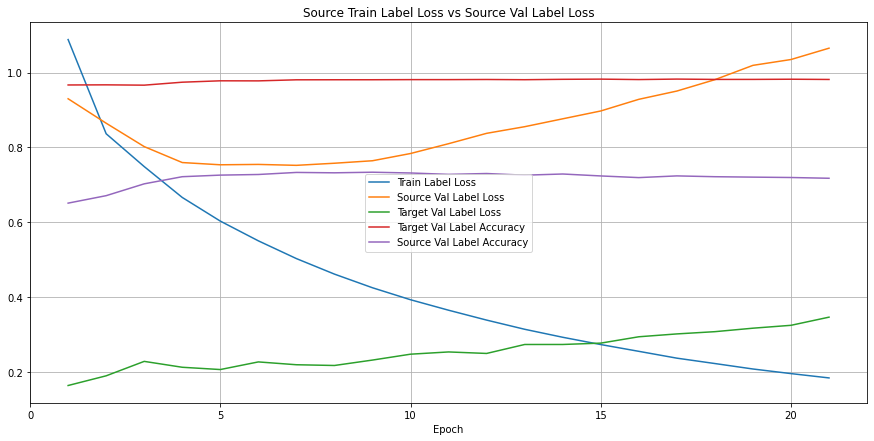

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

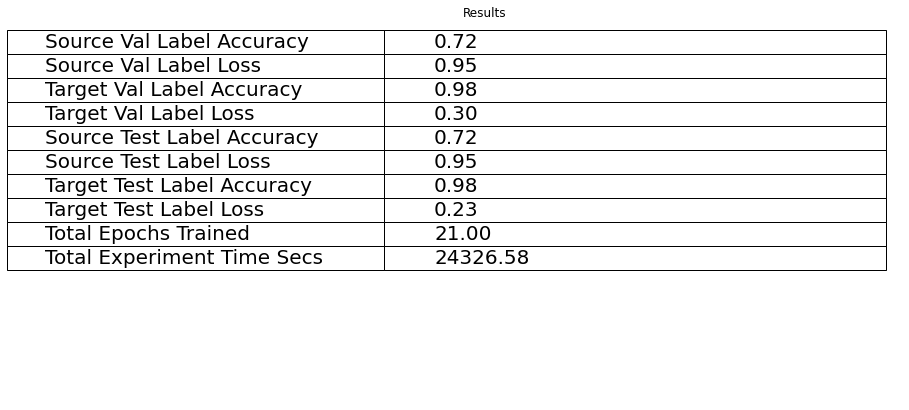

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

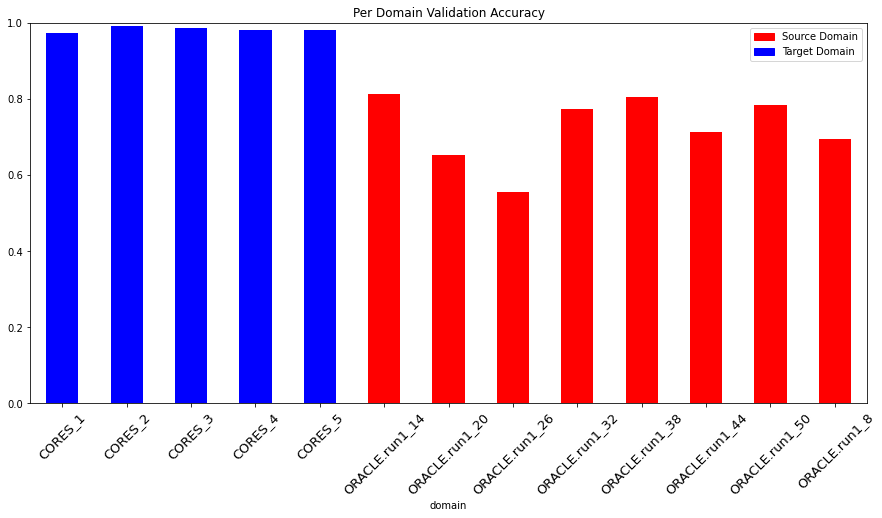

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7238541666666667 Target Test Label Accuracy: 0.9839365881032548
Source Val Label Accuracy: 0.7239322916666666 Target Val Label Accuracy: 0.9825913242009132


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:cores-oracle.run1", "parameters": {"experiment_name": "tl_1v2:cores-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL